In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy.stats import ttest_ind

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",100)
pd.set_option("expand_frame_repr", False)
pd.option_context("mode.dtype_backend","pyarrow")


### Data Loading & Understanding

In [6]:
df = pd.read_csv("train.csv",engine="pyarrow")


In [7]:
cols = [col.lower() for col in df.columns]

In [8]:
cols

['store',
 'dayofweek',
 'date',
 'sales',
 'customers',
 'open',
 'promo',
 'stateholiday',
 'schoolholiday']

In [9]:
df.columns = cols

In [10]:
df.shape

(1017209, 9)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   store          1017209 non-null  int64 
 1   dayofweek      1017209 non-null  int64 
 2   date           1017209 non-null  object
 3   sales          1017209 non-null  int64 
 4   customers      1017209 non-null  int64 
 5   open           1017209 non-null  int64 
 6   promo          1017209 non-null  int64 
 7   stateholiday   1017209 non-null  object
 8   schoolholiday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
df.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [12]:
# Converting Date Column to Datetime type
df["date"] = pd.to_datetime(df["date"])

In [13]:
mapping = {0:"No",1:"Yes"}
df["promo"] = df["promo"].apply(lambda x: mapping[x])
df["schoolholiday"] = df["schoolholiday"].apply(lambda x: mapping[x])

In [14]:
df.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday
0,1,5,2015-07-31,5263,555,1,Yes,0,Yes
1,2,5,2015-07-31,6064,625,1,Yes,0,Yes
2,3,5,2015-07-31,8314,821,1,Yes,0,Yes
3,4,5,2015-07-31,13995,1498,1,Yes,0,Yes
4,5,5,2015-07-31,4822,559,1,Yes,0,Yes


In [15]:
df["dayname"] = df["date"].dt.day_name()

In [16]:
df["dayname"]

0           Friday
1           Friday
2           Friday
3           Friday
4           Friday
            ...   
1017204    Tuesday
1017205    Tuesday
1017206    Tuesday
1017207    Tuesday
1017208    Tuesday
Name: dayname, Length: 1017209, dtype: object

### Check NaNs

In [17]:
df.isnull().sum()

store            0
dayofweek        0
date             0
sales            0
customers        0
open             0
promo            0
stateholiday     0
schoolholiday    0
dayname          0
dtype: int64

In [18]:
df.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,dayname
0,1,5,2015-07-31,5263,555,1,Yes,0,Yes,Friday
1,2,5,2015-07-31,6064,625,1,Yes,0,Yes,Friday
2,3,5,2015-07-31,8314,821,1,Yes,0,Yes,Friday
3,4,5,2015-07-31,13995,1498,1,Yes,0,Yes,Friday
4,5,5,2015-07-31,4822,559,1,Yes,0,Yes,Friday


### Creating Features

In [19]:
df["dayofyear"] = df["date"].dt.dayofyear
df["dayofmonth"] = df["date"].dt.day
df["weekofyear"] = df['date'].dt.isocalendar().week
df["quarter"] = df["date"].dt.quarter
df["month"] = df["date"].dt.month


In [20]:
df["salespercustomer"] = (df["sales"] / df["customers"]).fillna(0)

In [18]:
df.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,month,salespercustomer
0,1,5,2015-07-31,5263,555,1,Yes,0,Yes,Friday,212,31,31,3,7,9.482883
1,2,5,2015-07-31,6064,625,1,Yes,0,Yes,Friday,212,31,31,3,7,9.702400
2,3,5,2015-07-31,8314,821,1,Yes,0,Yes,Friday,212,31,31,3,7,10.126675
3,4,5,2015-07-31,13995,1498,1,Yes,0,Yes,Friday,212,31,31,3,7,9.342457
4,5,5,2015-07-31,4822,559,1,Yes,0,Yes,Friday,212,31,31,3,7,8.626118


In [19]:
df.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,month,salespercustomer
0,1,5,2015-07-31,5263,555,1,Yes,0,Yes,Friday,212,31,31,3,7,9.482883
1,2,5,2015-07-31,6064,625,1,Yes,0,Yes,Friday,212,31,31,3,7,9.702400
2,3,5,2015-07-31,8314,821,1,Yes,0,Yes,Friday,212,31,31,3,7,10.126675
3,4,5,2015-07-31,13995,1498,1,Yes,0,Yes,Friday,212,31,31,3,7,9.342457
4,5,5,2015-07-31,4822,559,1,Yes,0,Yes,Friday,212,31,31,3,7,8.626118


### Train Ready

In [21]:
store = pd.read_csv("store.csv",engine="pyarrow")

In [21]:
store.shape

(1115, 10)

In [22]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [23]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                  0
dtype: int64

In [22]:
store.loc[store["Promo2"] == 0, ["Promo2SinceWeek","Promo2SinceYear"]] = 0

In [25]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,


In [23]:
store[store["CompetitionDistance"].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,0.0,0.0,
621,622,a,c,NaN,NaN,NaN,0,0.0,0.0,
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [24]:
store["CompetitionDistance"] = store["CompetitionDistance"].fillna(method="ffill")

In [25]:
store[["CompetitionOpenSinceMonth","CompetitionOpenSinceYear"]] = store[["CompetitionOpenSinceMonth","CompetitionOpenSinceYear"]].fillna(method="ffill")

In [26]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [30]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [27]:
cols = [col.lower() for col in store.columns]

In [28]:
cols

['store',
 'storetype',
 'assortment',
 'competitiondistance',
 'competitionopensincemonth',
 'competitionopensinceyear',
 'promo2',
 'promo2sinceweek',
 'promo2sinceyear',
 'promointerval']

In [29]:
store.columns = cols

### Store Ready

### Joining the data

In [30]:
df = df.merge(store,on="store",how="inner")

### Data Ready to be analyzed

In [156]:
df.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,5,2015-07-31,5263,555,1,Yes,0,Yes,Friday,212,31,31,3,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,
1,1,4,2015-07-30,5020,546,1,Yes,0,Yes,Thursday,211,30,31,3,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,
2,1,3,2015-07-29,4782,523,1,Yes,0,Yes,Wednesday,210,29,31,3,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,
3,1,2,2015-07-28,5011,560,1,Yes,0,Yes,Tuesday,209,28,31,3,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,
4,1,1,2015-07-27,6102,612,1,Yes,0,Yes,Monday,208,27,31,3,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,


In [157]:
df.isnull().sum()

store                        0
dayofweek                    0
date                         0
sales                        0
customers                    0
open                         0
promo                        0
stateholiday                 0
schoolholiday                0
dayname                      0
dayofyear                    0
dayofmonth                   0
weekofyear                   0
quarter                      0
salespercustomer             0
storetype                    0
assortment                   0
competitiondistance          0
competitionopensincemonth    0
competitionopensinceyear     0
promo2                       0
promo2sinceweek              0
promo2sinceyear              0
promointerval                0
dtype: int64

In [31]:
df.loc[df["promointerval"]=="","promointerval"] = "None"

In [32]:
df.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,month,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,5,2015-07-31,5263,555,1,Yes,0,Yes,Friday,212,31,31,3,7,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,1,4,2015-07-30,5020,546,1,Yes,0,Yes,Thursday,211,30,31,3,7,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
2,1,3,2015-07-29,4782,523,1,Yes,0,Yes,Wednesday,210,29,31,3,7,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
3,1,2,2015-07-28,5011,560,1,Yes,0,Yes,Tuesday,209,28,31,3,7,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
4,1,1,2015-07-27,6102,612,1,Yes,0,Yes,Monday,208,27,31,3,7,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   date                       1017209 non-null  datetime64[ns]
 3   sales                      1017209 non-null  int64         
 4   customers                  1017209 non-null  int64         
 5   open                       1017209 non-null  int64         
 6   promo                      1017209 non-null  object        
 7   stateholiday               1017209 non-null  object        
 8   schoolholiday              1017209 non-null  object        
 9   dayname                    1017209 non-null  object        
 10  dayofyear                  1017209 non-null  int32         
 11  dayofmonth                 1017209 no

## Data Analysis & Analytics

### Descriptive Statistics

In [161]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
store,1017209.0,558.429727,1.0,280.0,558.0,838.0,1115.0,321.908651
dayofweek,1017209.0,3.998341,1.0,2.0,4.0,6.0,7.0,1.997391
date,1017209,2014-04-11 01:30:42.846061824,2013-01-01 00:00:00,2013-08-17 00:00:00,2014-04-02 00:00:00,2014-12-12 00:00:00,2015-07-31 00:00:00,NaN
sales,1017209.0,5773.818972,0.0,3727.0,5744.0,7856.0,41551.0,3849.926175
customers,1017209.0,633.145946,0.0,405.0,609.0,837.0,7388.0,464.411734
open,1017209.0,0.830107,0.0,1.0,1.0,1.0,1.0,0.375539
dayofyear,1017209.0,162.276385,1.0,77.0,153.0,241.0,365.0,101.616189
dayofmonth,1017209.0,15.70279,1.0,8.0,16.0,23.0,31.0,8.787638
weekofyear,1017209.0,23.615515,1.0,11.0,22.0,35.0,52.0,14.433381
quarter,1017209.0,2.294252,1.0,1.0,2.0,3.0,4.0,1.08185


#### Observations :
- 50 % of stores has sales lower than average and 50% upper than it.
- The Average Sales is ~5700 
- the sales column is normally distributed 
- Since the Std of sales is high, this means that the sale is spreaded out
- the customers are ~650 for each store on average.
- 75% of the stores are not following promo2 policy
- 

In [162]:
df.describe(include="O").T

,count,unique,top,freq
promo,1017209,2,No,629129
stateholiday,1017209,4,0,986159
schoolholiday,1017209,2,No,835488
dayname,1017209,7,Friday,145845
storetype,1017209,4,a,551627
assortment,1017209,3,a,537445
promointerval,1017209,4,None,508031


#### Observations
- more than 50% of the stores are "a" type
- more than 50% of the stores are "a" assortment


### Univariate Data Analysis

In [163]:
df.columns

Index(['store', 'dayofweek', 'date', 'sales', 'customers', 'open', 'promo',
       'stateholiday', 'schoolholiday', 'dayname', 'dayofyear', 'dayofmonth',
       'weekofyear', 'quarter', 'salespercustomer', 'storetype', 'assortment',
       'competitiondistance', 'competitionopensincemonth',
       'competitionopensinceyear', 'promo2', 'promo2sinceweek',
       'promo2sinceyear', 'promointerval'],
      dtype='object')

In [164]:
df.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,5,2015-07-31,5263,555,1,Yes,0,Yes,Friday,212,31,31,3,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,1,4,2015-07-30,5020,546,1,Yes,0,Yes,Thursday,211,30,31,3,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
2,1,3,2015-07-29,4782,523,1,Yes,0,Yes,Wednesday,210,29,31,3,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
3,1,2,2015-07-28,5011,560,1,Yes,0,Yes,Tuesday,209,28,31,3,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
4,1,1,2015-07-27,6102,612,1,Yes,0,Yes,Monday,208,27,31,3,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None


<Axes: xlabel='dayofweek', ylabel='count'>

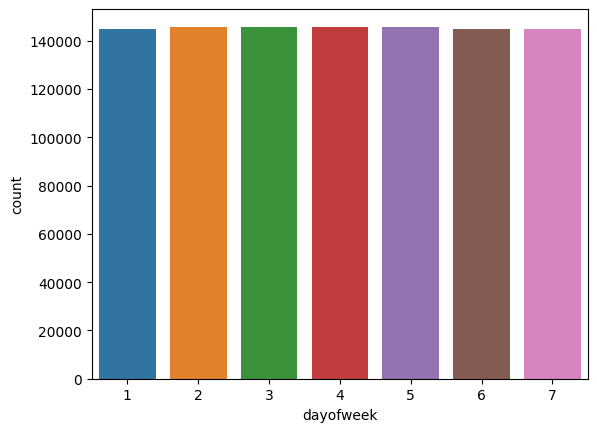

In [165]:
sns.countplot(data=df,x="dayofweek")

- all day of the weeks are distributed equally.


In [166]:
df["date"].value_counts().sort_index()

date
2013-01-01    1114
2013-01-02    1115
2013-01-03    1115
2013-01-04    1115
2013-01-05    1115
              ... 
2015-07-27    1115
2015-07-28    1115
2015-07-29    1115
2015-07-30    1115
2015-07-31    1115
Name: count, Length: 942, dtype: int64

- the data is representing 2 years of sales

In [34]:
df["year"] = df["date"].dt.year

C:\Users\Data\AppData\Local\Temp\ipykernel_2484\2518953778.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["sales"])


<Axes: xlabel='sales', ylabel='Density'>

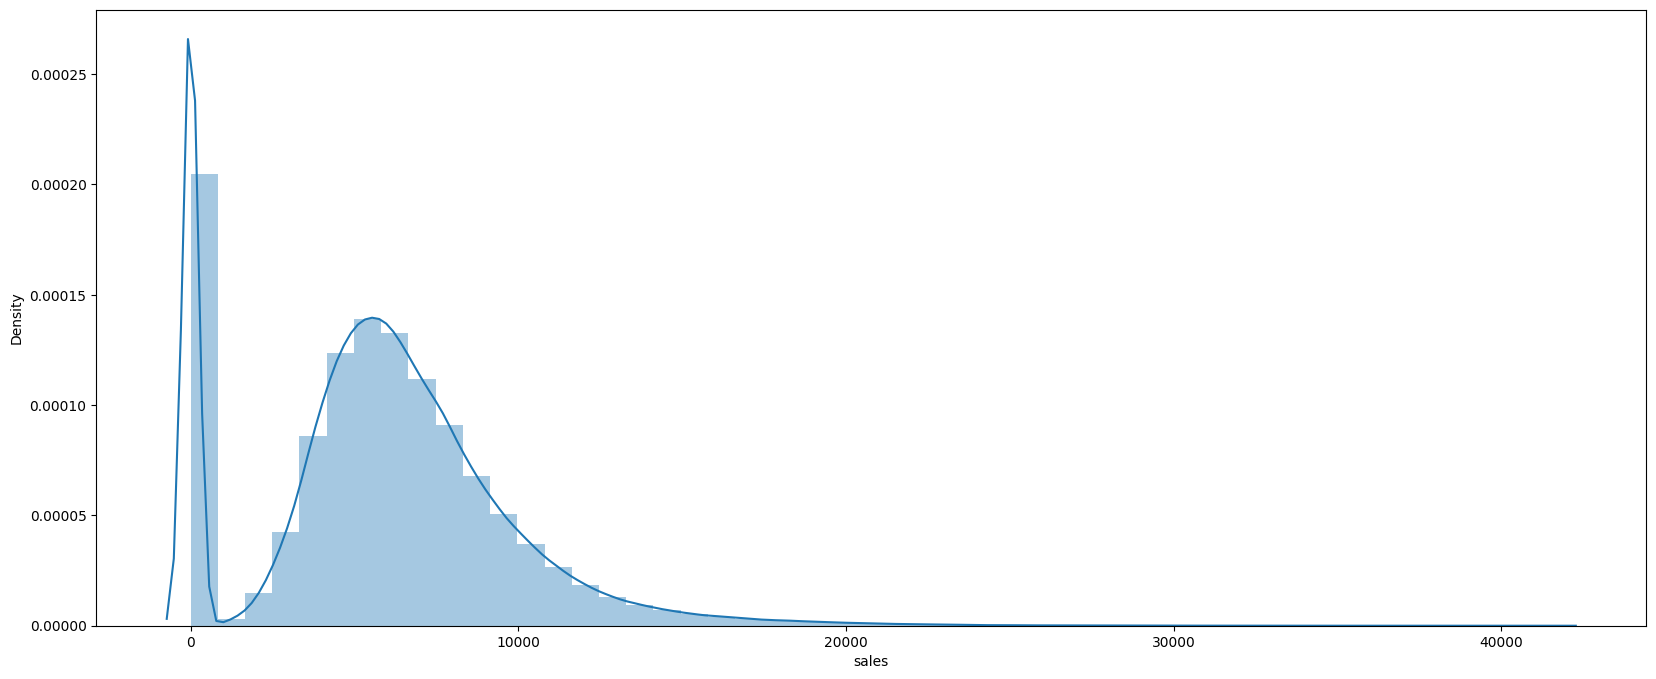

In [168]:
plt.figure(figsize=(20,8))
sns.distplot(df["sales"])

C:\Users\Data\AppData\Local\Temp\ipykernel_2484\934003841.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["customers"])


<Axes: xlabel='customers', ylabel='Density'>

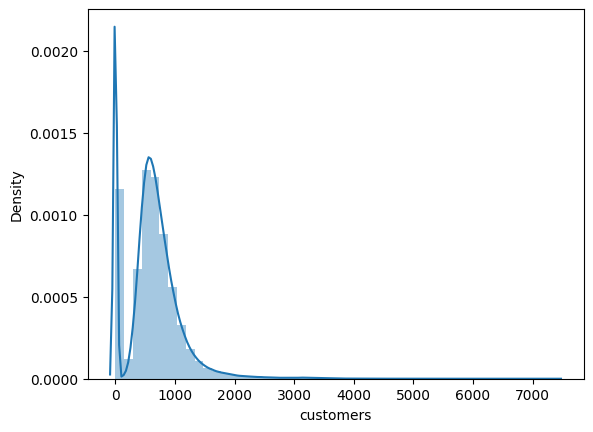

In [169]:
sns.distplot(df["customers"])

- most days the customers are between 0-2000 

In [112]:
df[df["customers"] > 2000]

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval,year
3039,4,2,2014-12-30,16860,2075,1,No,0,Yes,Tuesday,364,30,1,4,8.125301,c,c,620.0,9.0,2009.0,0,0.0,0.0,None,2014
3046,4,2,2014-12-23,15839,2071,1,No,0,Yes,Tuesday,357,23,52,4,7.647996,c,c,620.0,9.0,2009.0,0,0.0,0.0,None,2014
3404,4,1,2013-12-30,17412,2216,1,No,0,Yes,Monday,364,30,1,4,7.857401,c,c,620.0,9.0,2009.0,0,0.0,0.0,None,2013
3411,4,1,2013-12-23,16941,2139,1,No,0,Yes,Monday,357,23,52,4,7.920056,c,c,620.0,9.0,2009.0,0,0.0,0.0,None,2013
3679,4,6,2013-03-30,14669,2077,1,No,0,No,Saturday,89,30,13,1,7.062590,c,c,620.0,9.0,2009.0,0,0.0,0.0,None,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016260,1114,1,2013-01-07,21237,2962,1,Yes,0,No,Monday,7,7,2,1,7.169818,a,c,870.0,4.0,2006.0,0,0.0,0.0,None,2013
1016262,1114,6,2013-01-05,18856,3065,1,No,0,No,Saturday,5,5,1,1,6.152039,a,c,870.0,4.0,2006.0,0,0.0,0.0,None,2013
1016263,1114,5,2013-01-04,18371,3036,1,No,0,Yes,Friday,4,4,1,1,6.051054,a,c,870.0,4.0,2006.0,0,0.0,0.0,None,2013
1016264,1114,4,2013-01-03,18463,3211,1,No,0,Yes,Thursday,3,3,1,1,5.749922,a,c,870.0,4.0,2006.0,0,0.0,0.0,None,2013


<Axes: xlabel='open', ylabel='count'>

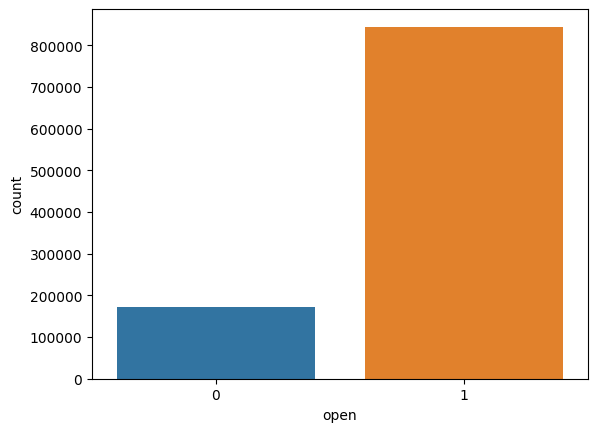

In [113]:
sns.countplot(data=df,x="open")

<Axes: xlabel='promo', ylabel='count'>

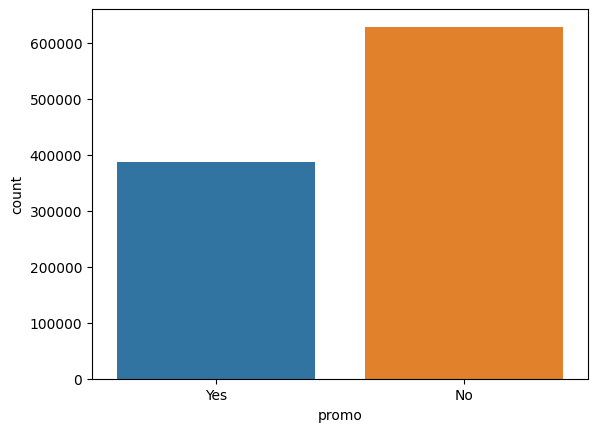

In [114]:
sns.countplot(data=df,x="promo")

In [ ]:
df["promo"].value_counts(normalize=True)

Promo
No     0.618483
Yes    0.381517
Name: proportion, dtype: float64

- 40% of the time the stores was applying promos

In [ ]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceSeason,year,sales_per_customer
0,1,Friday,2015-07-31,5263,555,Yes,Yes,none,Yes,c,a,1270.0,9.0,0,0,0,None,Autumn,2015,9.48
1,1,Thursday,2015-07-30,5020,546,Yes,Yes,none,Yes,c,a,1270.0,9.0,0,0,0,None,Autumn,2015,9.19
2,1,Wednesday,2015-07-29,4782,523,Yes,Yes,none,Yes,c,a,1270.0,9.0,0,0,0,None,Autumn,2015,9.14
3,1,Tuesday,2015-07-28,5011,560,Yes,Yes,none,Yes,c,a,1270.0,9.0,0,0,0,None,Autumn,2015,8.95
4,1,Monday,2015-07-27,6102,612,Yes,Yes,none,Yes,c,a,1270.0,9.0,0,0,0,None,Autumn,2015,9.97


<Axes: xlabel='Assortment', ylabel='count'>

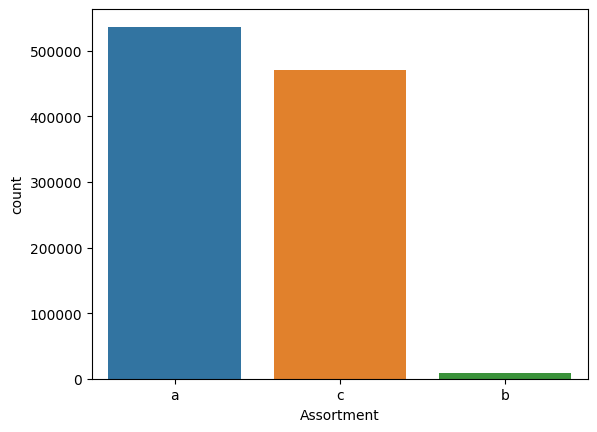

In [ ]:
sns.countplot(data=df,x="assortment")

In [ ]:
df["assortment"].value_counts(normalize=True)

Assortment
a    0.528491
c    0.463342
b    0.008167
Name: proportion, dtype: float64

- the less store count assortment is assortment "b"

In [ ]:
df[df["assortment"] == "b"]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceSeason,year,sales_per_customer
233630,259,Friday,2015-07-31,14096,2628,Yes,Yes,none,Yes,b,b,210.0,10.0,0,0,0,None,Autumn,2015,5.36
233631,259,Thursday,2015-07-30,12178,2477,Yes,Yes,none,Yes,b,b,210.0,10.0,0,0,0,None,Autumn,2015,4.92
233632,259,Wednesday,2015-07-29,11963,2467,Yes,Yes,none,Yes,b,b,210.0,10.0,0,0,0,None,Autumn,2015,4.85
233633,259,Tuesday,2015-07-28,12503,2496,Yes,Yes,none,Yes,b,b,210.0,10.0,0,0,0,None,Autumn,2015,5.01
233634,259,Monday,2015-07-27,12708,2562,Yes,Yes,none,Yes,b,b,210.0,10.0,0,0,0,None,Autumn,2015,4.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999284,1097,Saturday,2013-01-05,5460,1390,Yes,No,none,No,b,b,720.0,3.0,0,0,0,None,Spring,2013,3.93
999285,1097,Friday,2013-01-04,6430,1799,Yes,No,none,Yes,b,b,720.0,3.0,0,0,0,None,Spring,2013,3.57
999286,1097,Thursday,2013-01-03,7053,1803,Yes,No,none,Yes,b,b,720.0,3.0,0,0,0,None,Spring,2013,3.91
999287,1097,Wednesday,2013-01-02,6688,1819,Yes,No,none,Yes,b,b,720.0,3.0,0,0,0,None,Spring,2013,3.68


<Axes: xlabel='StoreType', ylabel='count'>

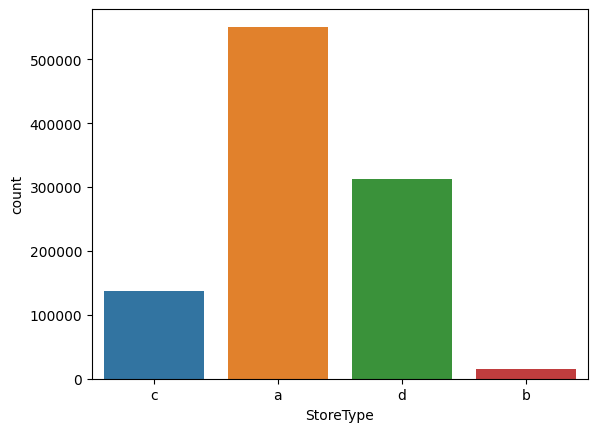

In [ ]:
sns.countplot(data=df,x="storetype")

In [ ]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceSeason,sales_per_customer
0,1,Friday,2015-07-31,5263,555,Yes,Yes,none,Yes,c,a,1270.0,9.0,0,0,0,None,Autumn,9.48
1,1,Thursday,2015-07-30,5020,546,Yes,Yes,none,Yes,c,a,1270.0,9.0,0,0,0,None,Autumn,9.19
2,1,Wednesday,2015-07-29,4782,523,Yes,Yes,none,Yes,c,a,1270.0,9.0,0,0,0,None,Autumn,9.14
3,1,Tuesday,2015-07-28,5011,560,Yes,Yes,none,Yes,c,a,1270.0,9.0,0,0,0,None,Autumn,8.95
4,1,Monday,2015-07-27,6102,612,Yes,Yes,none,Yes,c,a,1270.0,9.0,0,0,0,None,Autumn,9.97


C:\Users\Data\AppData\Local\Temp\ipykernel_2876\959245872.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["CompetitionDistance"])


<Axes: xlabel='CompetitionDistance', ylabel='Density'>

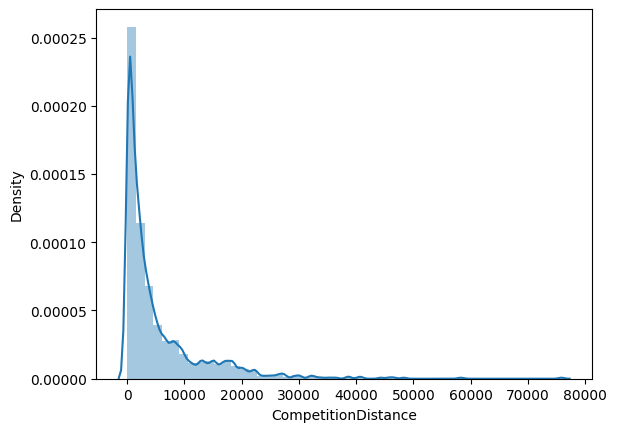

In [ ]:
sns.distplot(df["competitiondistance"])

In [ ]:
df["competitiondistance"].max()

75860.0

In [ ]:
df[df["CompetitionDistance"] == 100]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceSeason,sales_per_customer
148600,166,Friday,2015-07-31,6588,898,Yes,Yes,none,Yes,a,c,100.0,4.0,1,31,2013,"Jan,Apr,Jul,Oct",Spring,7.34
148601,166,Thursday,2015-07-30,7130,877,Yes,Yes,none,Yes,a,c,100.0,4.0,1,31,2013,"Jan,Apr,Jul,Oct",Spring,8.13
148602,166,Wednesday,2015-07-29,5502,743,Yes,Yes,none,Yes,a,c,100.0,4.0,1,31,2013,"Jan,Apr,Jul,Oct",Spring,7.41
148603,166,Tuesday,2015-07-28,5598,737,Yes,Yes,none,Yes,a,c,100.0,4.0,1,31,2013,"Jan,Apr,Jul,Oct",Spring,7.60
148604,166,Monday,2015-07-27,6709,770,Yes,Yes,none,Yes,a,c,100.0,4.0,1,31,2013,"Jan,Apr,Jul,Oct",Spring,8.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700657,770,Saturday,2013-01-05,4405,546,Yes,No,none,No,a,c,100.0,4.0,0,0,0,None,Spring,8.07
700658,770,Friday,2013-01-04,5826,757,Yes,No,none,Yes,a,c,100.0,4.0,0,0,0,None,Spring,7.70
700659,770,Thursday,2013-01-03,5397,700,Yes,No,none,Yes,a,c,100.0,4.0,0,0,0,None,Spring,7.71
700660,770,Wednesday,2013-01-02,6299,810,Yes,No,none,Yes,a,c,100.0,4.0,0,0,0,None,Spring,7.78


<Axes: >

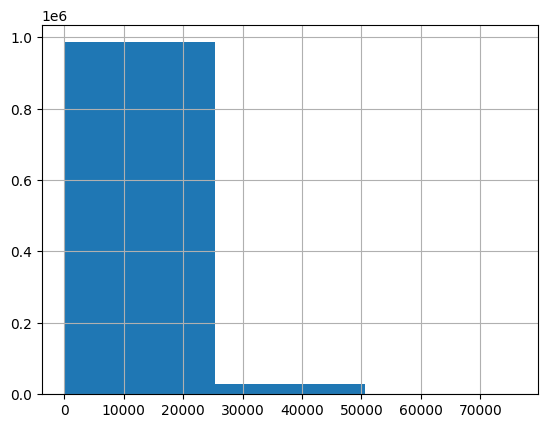

In [ ]:
df["competitiondistance"].hist(bins=3)

### Analysis Questions

- which day of the week has the most sales ? tuesday and monday and it has effect on the sales
- is having promo effect the sales ? yes
- is having promo effect the number of customers ? yes
- which season has the most sales? winter but there's no significent differnce
- is school holidays effect the sales ? yes
- which year has the most sales? 2015 but there's no significant difference
- which stores has the highest customer price and what are their charectrestics? close from the competitior
- is there's a correlation between competition distance and sales ? yes
- what' the stores that have the highest and lowest sales?


<Axes: xlabel='dayofweek'>

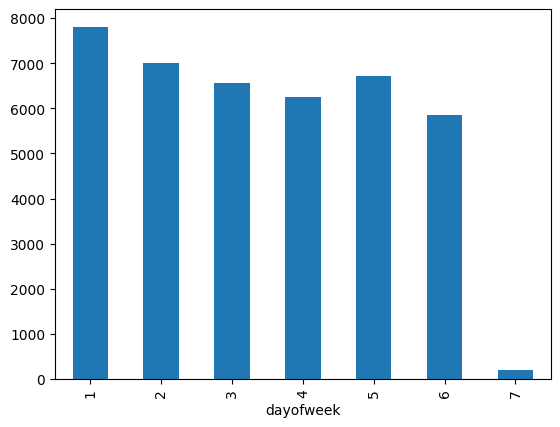

In [115]:

df.groupby("dayofweek",as_index=True)["sales"].mean().plot.bar()

In [172]:
other_days = df[~df["dayname"].isin(["Monday","Tuesday"])]["sales"]
mon_tue_stores = df[df["dayname"].isin(["Monday","Tuesday"])]["sales"]

In [173]:
from scipy.stats import ttest_ind
result = ttest_ind(other_days,mon_tue_stores)

In [174]:
print("%.9f" % result[1])

0.000000000


the day effect the sales so we reject the null hypothesis.

In [176]:
df.groupby("promo",as_index=False)[["sales","customers"]].mean()

,promo,sales,customers
0,No,4406.050805,517.823542
1,Yes,7991.152046,820.098815


In [177]:
df["promo"]

0          Yes
1          Yes
2          Yes
3          Yes
4          Yes
          ... 
1017204     No
1017205     No
1017206     No
1017207     No
1017208     No
Name: promo, Length: 1017209, dtype: object

In [179]:
promo_sales = df[df["promo"] == "Yes"]["sales"]
not_promo_sales = df[df["promo"] != "Yes"]["sales"]

In [180]:
result = ttest_ind(promo_sales,not_promo_sales)
print("%.9f" % result[1])

0.000000000


In [ ]:
not_promo_sales

5             0
6          4364
7          3706
8          3769
9          3464
           ... 
1015504    4771
1015505    4540
1015506    4297
1015507    3697
1015508       0
Name: Sales, Length: 628075, dtype: int64

- the promo is effecting the number of sales

In [183]:
promo_customers = df[df["promo"] == "Yes"]["customers"]
not_promo_customers = df[df["promo"] != "Yes"]["customers"]
result = ttest_ind(promo_customers,not_promo_customers)
print("%.9f" % result[1])

0.000000000


<Axes: xlabel='customers', ylabel='sales'>

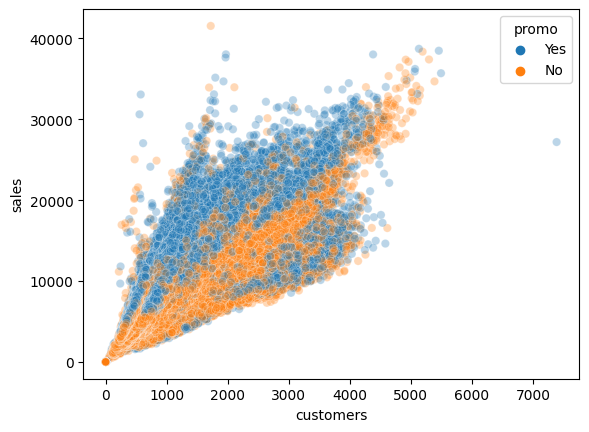

In [184]:
sns.scatterplot(data=df,x="customers",y="sales",hue="promo",alpha=0.3)

- Having Promo effecting the number of sales and number of customers

In [185]:
xx = df.groupby("schoolholiday")["sales"].mean()

<Axes: xlabel='schoolholiday'>

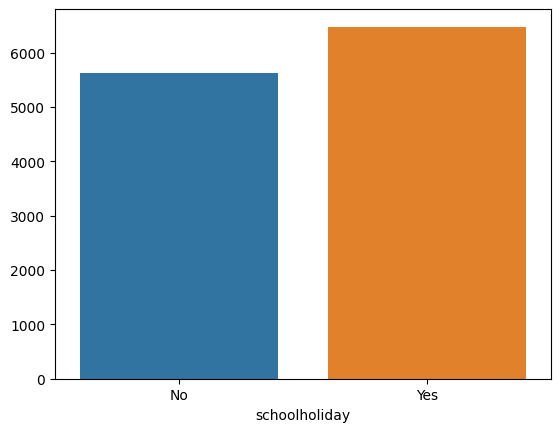

In [186]:
sns.barplot(x=xx.index,y = xx.values)

In [187]:
no_holiday = df[df["schoolholiday"] == "Yes"]["sales"]
holiday = df[df["schoolholiday"] != "Yes"]["sales"]
result = ttest_ind(no_holiday,holiday)
print("%.9f" % result[1])

0.000000000


In [ ]:
df.corr(numeric_only=True)

,Store,Sales,Customers,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,Promo2SinceYear,sales_per_customer,year
Store,1.0,0.005175341849003723,0.02417906948504685,-0.025648672981397343,-0.029488239378938297,0.009097251247302157,0.0128337394009991,0.009128970360898797,-0.021393996019617535,0.00032442505854777805
Sales,0.005175341849003723,1.0,0.8947229127681025,-0.01914651986223417,-0.027481291012109537,-0.09156983310905174,-0.0451475228397396,-0.09158641829461181,0.6583272590247788,0.02370293503886014
Customers,0.02417906948504685,0.8947229127681025,1.0,-0.1027666086631295,-0.029940639408730672,-0.15029782779509146,-0.0986059137182732,-0.15027793979840923,0.41249825787710376,-0.0010652527266090737
CompetitionDistance,-0.025648672981397343,-0.01914651986223417,-0.1027666086631295,1.0,-0.03335040822777911,-0.13969143206633555,-0.12402964289845299,-0.13975389572037536,0.1000597686464886,0.0006804402635686119
CompetitionOpenSinceMonth,-0.029488239378938297,-0.027481291012109537,-0.029940639408730672,-0.03335040822777911,1.0,-0.023615407051991937,-0.035704705429636184,-0.023564739072052997,-0.0063340788586916975,-4.167853341058402e-05
Promo2,0.009097251247302157,-0.09156983310905174,-0.15029782779509146,-0.13969143206633555,-0.023615407051991937,1.0,0.7592521315000088,0.999999316747119,0.08883725344511281,-0.004964152210787204
Promo2SinceWeek,0.0128337394009991,-0.0451475228397396,-0.0986059137182732,-0.12402964289845299,-0.035704705429636184,0.7592521315000088,1.0,0.7590626754992501,0.0816921853259116,-0.00611898012690607
Promo2SinceYear,0.009128970360898797,-0.09158641829461181,-0.15027793979840923,-0.13975389572037536,-0.023564739072052997,0.999999316747119,0.7590626754992501,1.0,0.08878870475433946,-0.004965274592289387
sales_per_customer,-0.021393996019617535,0.6583272590247788,0.41249825787710376,0.1000597686464886,-0.0063340788586916975,0.08883725344511281,0.0816921853259116,0.08878870475433946,1.0,0.03163639946775832
year,0.00032442505854777805,0.02370293503886014,-0.0010652527266090737,0.0006804402635686119,-4.167853341058402e-05,-0.004964152210787204,-0.00611898012690607,-0.004965274592289387,0.03163639946775832,1.0


<Axes: >

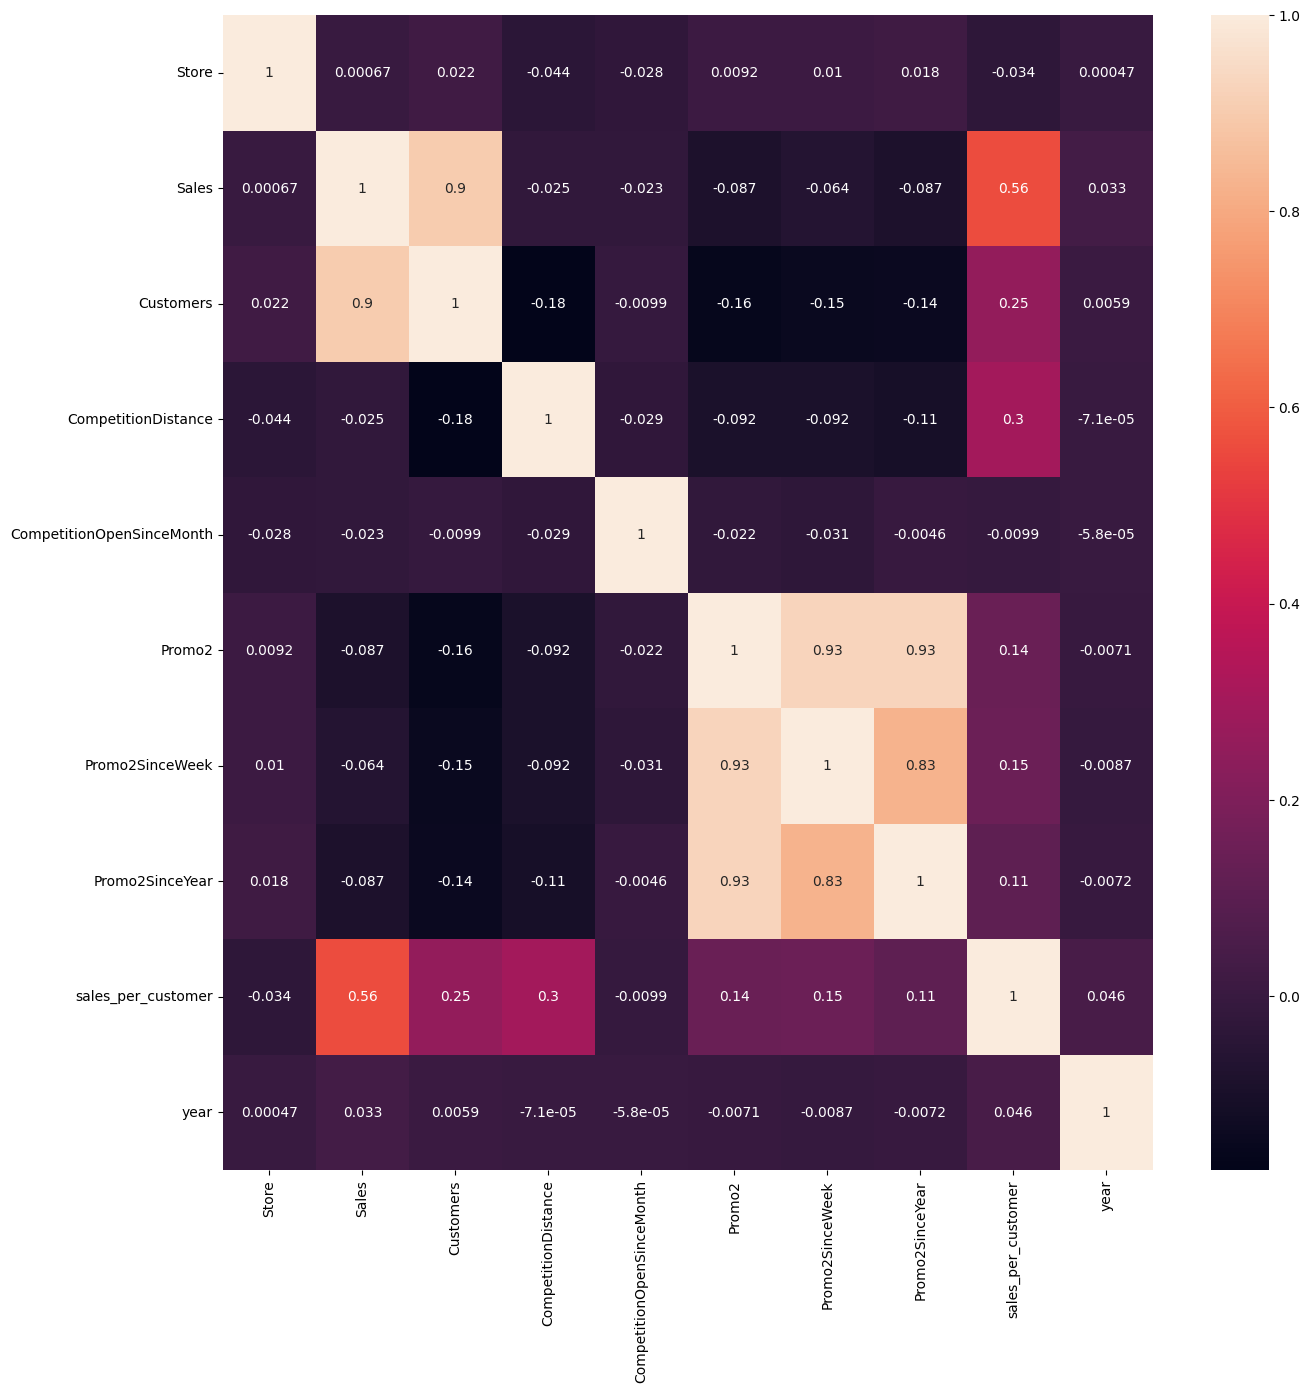

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(method="spearman",numeric_only=True),annot=True)

In [189]:
df.columns

Index(['store', 'dayofweek', 'date', 'sales', 'customers', 'open', 'promo',
       'stateholiday', 'schoolholiday', 'dayname', 'dayofyear', 'dayofmonth',
       'weekofyear', 'quarter', 'salespercustomer', 'storetype', 'assortment',
       'competitiondistance', 'competitionopensincemonth',
       'competitionopensinceyear', 'promo2', 'promo2sinceweek',
       'promo2sinceyear', 'promointerval', 'year'],
      dtype='object')

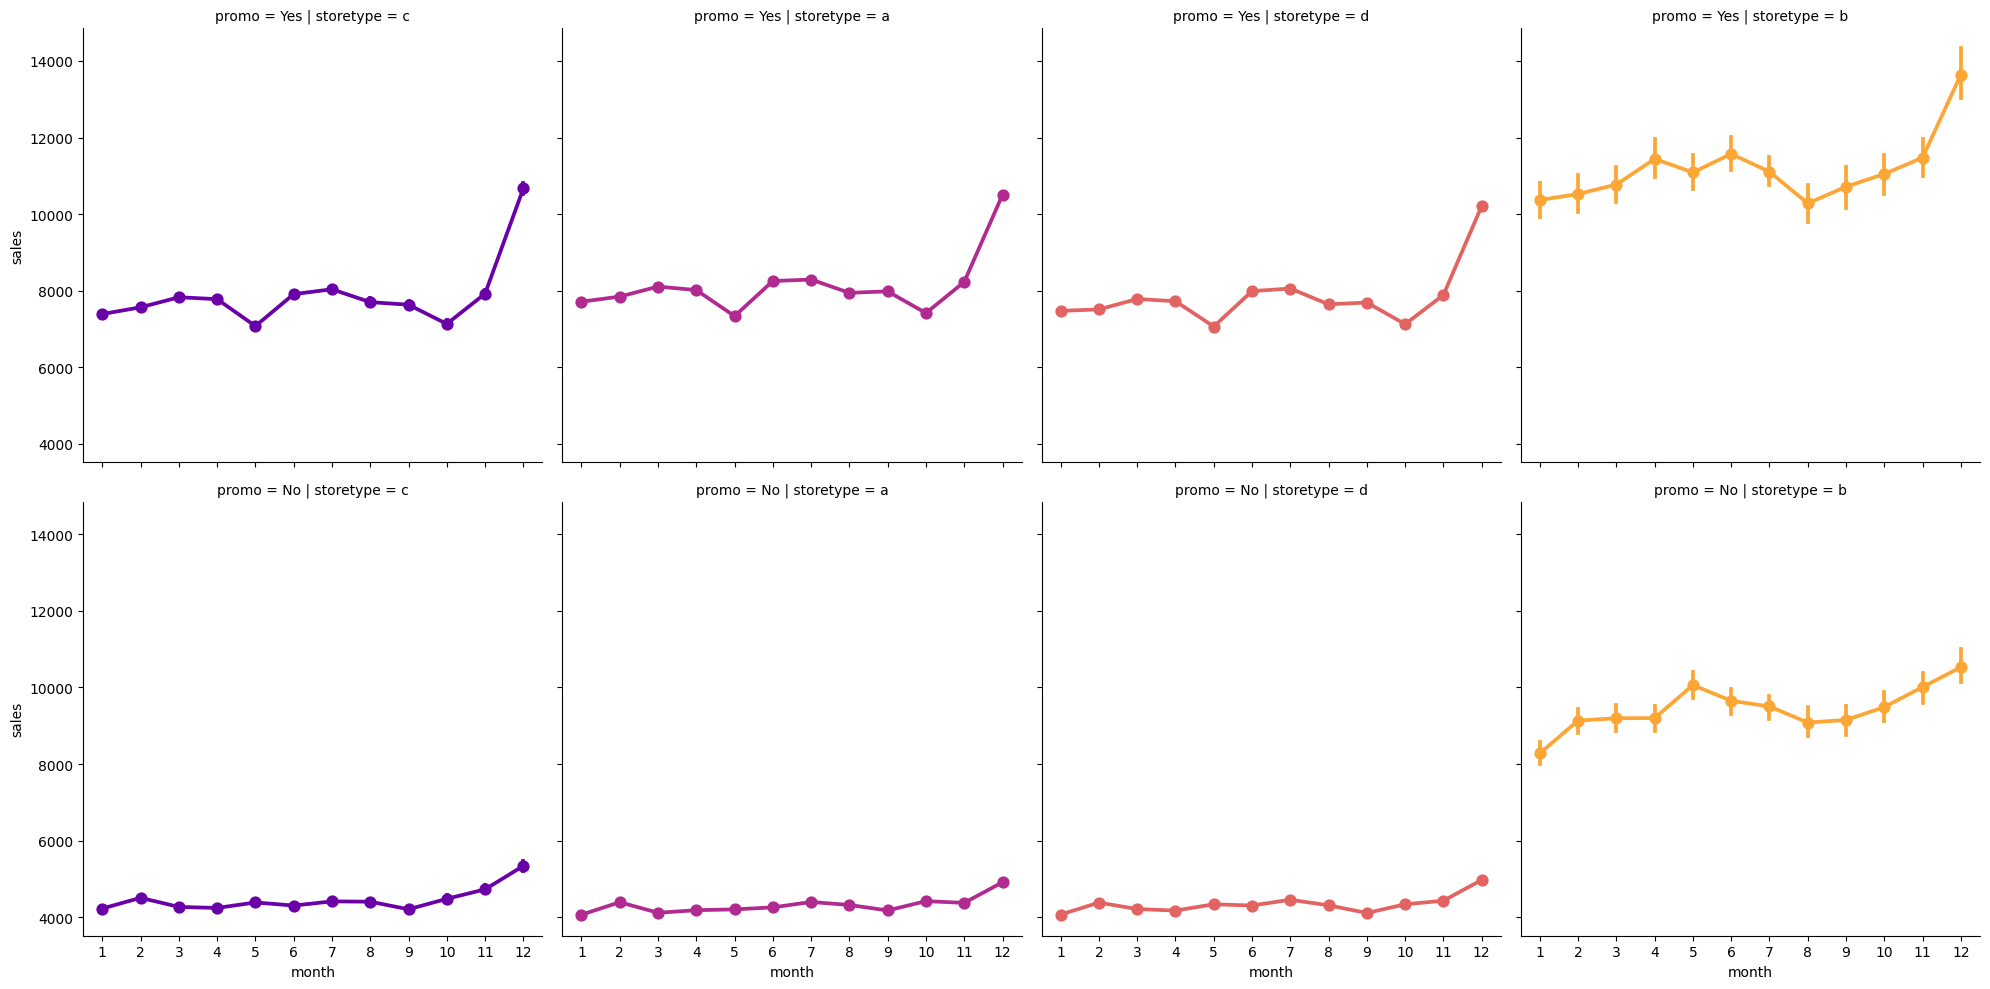

In [191]:
sns.catplot(data = df, x = 'month', y = "sales", 
               col = 'storetype', # per store type in cols
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', # per promo in the store in rows
               color = "blue",kind="point") 

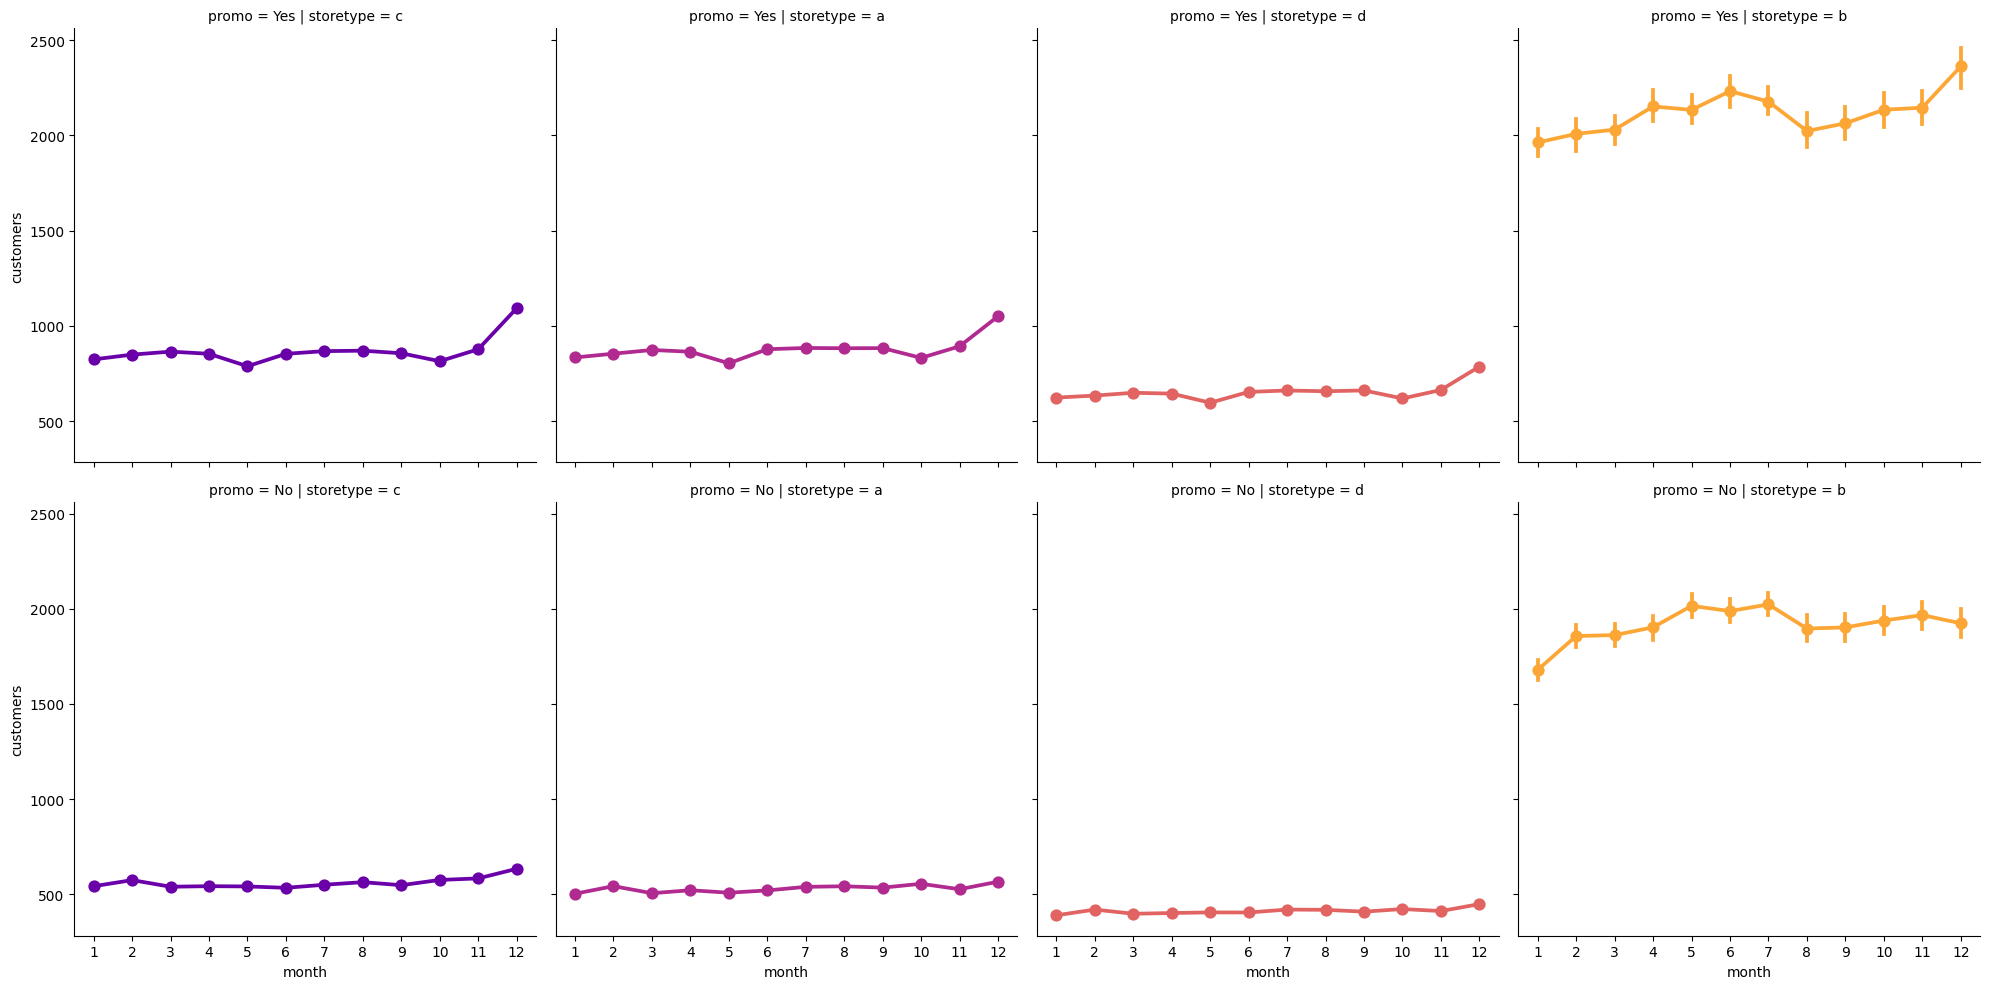

In [193]:
sns.catplot(data = df, x = 'month', y = "customers", 
               col = 'storetype', # per store type in cols
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', # per promo in the store in rows
               color = "blue",kind="point") 

### Model Building

#### Date Preprocessing

In [46]:
df.head()

,store,dayofweek,date,sales,customers,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,5,2015-07-31,5263,555,Yes,0,Yes,Friday,212,31,31,3,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,1,4,2015-07-30,5020,546,Yes,0,Yes,Thursday,211,30,31,3,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
2,1,3,2015-07-29,4782,523,Yes,0,Yes,Wednesday,210,29,31,3,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
3,1,2,2015-07-28,5011,560,Yes,0,Yes,Tuesday,209,28,31,3,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
4,1,1,2015-07-27,6102,612,Yes,0,Yes,Monday,208,27,31,3,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None


In [35]:
df = df.drop("open",axis=1)

In [36]:
df["promo"] = df.promo.map({"Yes":1,"No":0})

In [37]:
df["stateholiday"].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [38]:
df["stateholiday"] = df["stateholiday"].map({"0":0,"a":1,"b":1,"c":1})

In [41]:
df.head()

,store,dayofweek,date,sales,customers,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,month,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval,year
0,1,5,2015-07-31,5263,555,1,0,Yes,Friday,212,31,31,3,7,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
1,1,4,2015-07-30,5020,546,1,0,Yes,Thursday,211,30,31,3,7,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
2,1,3,2015-07-29,4782,523,1,0,Yes,Wednesday,210,29,31,3,7,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
3,1,2,2015-07-28,5011,560,1,0,Yes,Tuesday,209,28,31,3,7,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
4,1,1,2015-07-27,6102,612,1,0,Yes,Monday,208,27,31,3,7,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None,2015


In [39]:
df["schoolholiday"] = df["schoolholiday"].map({"Yes":1,"No":0})

In [281]:
df["storetype"].value_counts()

storetype
a    551627
d    312912
c    136840
b     15830
Name: count, dtype: int64

In [40]:
mappings = {"a":1,"b":2,"c":3,"d":4}
df["storetype"] = df["storetype"].apply(lambda x: mappings[x])

In [44]:
df.head()

,store,dayofweek,date,sales,customers,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,month,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval,year
0,1,5,2015-07-31,5263,555,1,0,1,Friday,212,31,31,3,7,9.482883,3,a,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
1,1,4,2015-07-30,5020,546,1,0,1,Thursday,211,30,31,3,7,9.194139,3,a,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
2,1,3,2015-07-29,4782,523,1,0,1,Wednesday,210,29,31,3,7,9.143403,3,a,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
3,1,2,2015-07-28,5011,560,1,0,1,Tuesday,209,28,31,3,7,8.948214,3,a,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
4,1,1,2015-07-27,6102,612,1,0,1,Monday,208,27,31,3,7,9.970588,3,a,1270.0,9.0,2008.0,0,0.0,0.0,None,2015


In [46]:
df["assortment"].value_counts()

assortment
a    537445
c    471470
b      8294
Name: count, dtype: int64

In [41]:
mappings = {"a":1,"b":2,"c":3}
df["assortment"] = df["assortment"].apply(lambda x: mappings[x])

In [48]:
df.head()

,store,dayofweek,date,sales,customers,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,month,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval,year
0,1,5,2015-07-31,5263,555,1,0,1,Friday,212,31,31,3,7,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
1,1,4,2015-07-30,5020,546,1,0,1,Thursday,211,30,31,3,7,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
2,1,3,2015-07-29,4782,523,1,0,1,Wednesday,210,29,31,3,7,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
3,1,2,2015-07-28,5011,560,1,0,1,Tuesday,209,28,31,3,7,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0,None,2015
4,1,1,2015-07-27,6102,612,1,0,1,Monday,208,27,31,3,7,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0,None,2015


In [42]:
df = df.drop("promointerval",axis=1)

In [43]:
df = df[df["sales"] != 0]

In [51]:
df

,store,dayofweek,date,sales,customers,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,month,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,year
0,1,5,2015-07-31,5263,555,1,0,1,Friday,212,31,31,3,7,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015
1,1,4,2015-07-30,5020,546,1,0,1,Thursday,211,30,31,3,7,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015
2,1,3,2015-07-29,4782,523,1,0,1,Wednesday,210,29,31,3,7,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015
3,1,2,2015-07-28,5011,560,1,0,1,Tuesday,209,28,31,3,7,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015
4,1,1,2015-07-27,6102,612,1,0,1,Monday,208,27,31,3,7,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1115,1,2013-01-07,6905,471,1,0,1,Monday,7,7,2,1,1,14.660297,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2013
1017204,1115,6,2013-01-05,4771,339,0,0,1,Saturday,5,5,1,1,1,14.073746,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2013
1017205,1115,5,2013-01-04,4540,326,0,0,1,Friday,4,4,1,1,1,13.926380,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2013
1017206,1115,4,2013-01-03,4297,300,0,0,1,Thursday,3,3,1,1,1,14.323333,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2013


In [46]:
df = df.drop("dayname",axis=1)

In [47]:
df = df.set_index("date")

KeyError: "None of ['date'] are in the columns"

In [48]:
df

,store,dayofweek,sales,customers,promo,stateholiday,schoolholiday,dayofyear,dayofmonth,weekofyear,quarter,month,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,year
date,,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,0,1,212,31,31,3,7,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015
2015-07-30,1,4,5020,546,1,0,1,211,30,31,3,7,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015
2015-07-29,1,3,4782,523,1,0,1,210,29,31,3,7,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015
2015-07-28,1,2,5011,560,1,0,1,209,28,31,3,7,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015
2015-07-27,1,1,6102,612,1,0,1,208,27,31,3,7,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-07,1115,1,6905,471,1,0,1,7,7,2,1,1,14.660297,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2013
2013-01-05,1115,6,4771,339,0,0,1,5,5,1,1,1,14.073746,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2013
2013-01-04,1115,5,4540,326,0,0,1,4,4,1,1,1,13.926380,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2013


### Data Ready

### Splitting the data

In [217]:
df

,store,dayofweek,sales,customers,promo,stateholiday,schoolholiday,dayname,dayofyear,dayofmonth,weekofyear,quarter,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,year,month
date,,,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,0,1,Friday,212,31,31,3,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7
2015-07-30,1,4,5020,546,1,0,1,Thursday,211,30,31,3,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7
2015-07-29,1,3,4782,523,1,0,1,Wednesday,210,29,31,3,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7
2015-07-28,1,2,5011,560,1,0,1,Tuesday,209,28,31,3,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7
2015-07-27,1,1,6102,612,1,0,1,Monday,208,27,31,3,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-07,1115,1,6905,471,1,0,1,Monday,7,7,2,1,14.660297,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2013,1
2013-01-05,1115,6,4771,339,0,0,1,Saturday,5,5,1,1,14.073746,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2013,1
2013-01-04,1115,5,4540,326,0,0,1,Friday,4,4,1,1,13.926380,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2013,1


In [56]:
train = df.loc[:"2015-06-19"]
test  = df.loc["2015-06-19":]

In [58]:
x_train = train.drop("sales",axis=1)
y_train = train["sales"]
x_test = test.drop("sales",axis=1)
y_test = test["sales"]

In [67]:
x_train["week"] = x_train["weekofyear"].astype("int32")
x_test["week"] = x_test["weekofyear"].astype("int32")
x_train = x_train.drop("weekofyear",axis=1)
x_test = x_test.drop("weekofyear",axis=1)

In [66]:
x_train.dtypes

store                          int64
dayofweek                      int64
customers                      int64
promo                          int64
stateholiday                   int64
schoolholiday                  int64
dayofyear                      int32
dayofmonth                     int32
weekofyear                    UInt32
quarter                        int32
month                          int32
salespercustomer             float64
storetype                      int64
assortment                     int64
competitiondistance          float64
competitionopensincemonth    float64
competitionopensinceyear     float64
promo2                         int64
promo2sinceweek              float64
promo2sinceyear              float64
year                           int32
week                           int32
dtype: object

### Model Training

#### Xgboost

In [68]:
model = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds = 50)
model.fit(x_train,y_train,
          eval_set=[(x_train,y_train),(x_test,y_test)],
          verbose=100
          )

[0]	validation_0-rmse:5352.88836	validation_1-rmse:5371.13239
[100]	validation_0-rmse:74.12321	validation_1-rmse:89.74452
[200]	validation_0-rmse:49.48636	validation_1-rmse:70.81552
[300]	validation_0-rmse:38.29599	validation_1-rmse:62.25616
[400]	validation_0-rmse:30.54546	validation_1-rmse:56.92414
[500]	validation_0-rmse:26.32682	validation_1-rmse:54.51949
[600]	validation_0-rmse:22.94993	validation_1-rmse:52.83261
[700]	validation_0-rmse:20.73713	validation_1-rmse:51.84133
[800]	validation_0-rmse:19.07071	validation_1-rmse:51.18812
[900]	validation_0-rmse:17.37419	validation_1-rmse:50.62346
[999]	validation_0-rmse:16.24151	validation_1-rmse:50.23357


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [69]:
preds = model.predict(x_test)
x_test["pred"] = preds

In [75]:
pd.concat([x_test,y_test],axis=1)

,store,dayofweek,customers,promo,stateholiday,schoolholiday,dayofyear,dayofmonth,quarter,month,salespercustomer,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,year,week,pred,sales
date,,,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,555,1,0,1,212,31,3,7,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,31,5285.074219,5263
2015-07-30,1,4,546,1,0,1,211,30,3,7,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,31,5039.577148,5020
2015-07-29,1,3,523,1,0,1,210,29,3,7,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,31,4795.336426,4782
2015-07-28,1,2,560,1,0,1,209,28,3,7,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,31,5017.735352,5011
2015-07-27,1,1,612,1,0,1,208,27,3,7,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,31,6088.572266,6102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-24,1115,3,391,0,0,0,175,24,2,6,13.971867,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2015,26,5468.409180,5463
2015-06-23,1115,2,392,0,0,0,174,23,2,6,13.155612,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2015,26,5156.665527,5157
2015-06-22,1115,1,375,0,0,0,173,22,2,6,13.589333,4,3,5350.0,4.0,2006.0,1,22.0,2012.0,2015,26,5108.483398,5096


#### Feature Importances

In [80]:
model_1 = pd.DataFrame(data=model.feature_importances_,index=model.feature_names_in_,columns=["importance"]).sort_values(by="importance",ascending=False)

,importance
customers,0.748260
salespercustomer,0.228207
competitiondistance,0.021653
competitionopensincemonth,0.000397
promo2sinceweek,0.000346
competitionopensinceyear,0.000339
stateholiday,0.000156
store,0.000134
storetype,0.000100
assortment,0.000081


In [ ]:
x_train_without_customers = x_train.drop(["customers","salespercustomer"],axis=1)
x_test_without_customers = x_test.drop(["customers","salespercustomer"],axis=1)

In [85]:
x_train_without_customers.shape

(804056, 19)

In [91]:
x_test_without_customers = x_test_without_customers.drop("pred",axis=1)

In [92]:
model2 = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds = 50)
model.fit(x_train_without_customers,y_train,
          eval_set=[(x_train_without_customers,y_train),(x_test_without_customers,y_test)],
          verbose=100
          )

[0]	validation_0-rmse:5652.47199	validation_1-rmse:5703.14709
[100]	validation_0-rmse:1091.56243	validation_1-rmse:1270.01753
[200]	validation_0-rmse:907.87288	validation_1-rmse:1141.78850
[300]	validation_0-rmse:829.32980	validation_1-rmse:1092.96397
[400]	validation_0-rmse:778.48223	validation_1-rmse:1061.80501
[500]	validation_0-rmse:742.15984	validation_1-rmse:1045.79430
[600]	validation_0-rmse:716.57269	validation_1-rmse:1034.90118
[700]	validation_0-rmse:696.42405	validation_1-rmse:1027.59823
[800]	validation_0-rmse:679.37570	validation_1-rmse:1025.94434
[900]	validation_0-rmse:664.91162	validation_1-rmse:1017.19769
[999]	validation_0-rmse:651.95535	validation_1-rmse:1012.80373


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
preds_without = model.predict(x_test_without_customers)
x_test_without_customers["preds"] = preds_without
predictions = pd.concat([y_test,x_test_without_customers["preds"]],axis=1)